Install Dependencies (Colab only)

In [1]:
!pip install virtualenv
!virtualenv venv_task_2
!source venv/bin/activate
!pip install faster-whisper
!pip install evaluate==0.4.0
!pip install jiwer
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 57.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 75.4 MB/s eta 0:00:00
created virtual environment CPython3.10.12.final.0-64 in 454ms
  creator CPython3Posix(dest=/home/concina/telephaty/ASR_challenge_Telepathy/notebooks/venv_task_2, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/home/concina/.local/share/virtualenv)
    added seed packages: pip==24.2, setuptools==74.1.2, wheel==0.44.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator
/bin/bash: line 1: venv/bin/activate: No such file or directory


Mount Google Drive to load audio files (Colab only)

In [106]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import jiwer
from evaluate import load
from faster_whisper import WhisperModel
from faster_whisper.utils import download_model
import matplotlib.pyplot as plt


/home/concina/telephaty/ASR_challenge_Telepathy/venv_challenge_task_2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Download Whisper model from HuggingFace hub

In [108]:
model_size = 'Systran/faster-whisper-tiny.en'  #https://huggingface.co/Systran/faster-whisper-tiny.en
model_folder = '/content/drive/My Drive/Telephaty_challenge/whisper_model'

#ensure the model folder exists
os.makedirs(model_folder, exist_ok=True)

model_path = download_model(
                size_or_id=model_size,
                output_dir=model_folder,
            )
print(f"Model {model_size} save at location {model_folder}")

Model Systran/faster-whisper-tiny.en save at location /content/drive/My Drive/Telephaty_challenge/whisper_model


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1212: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Define all important paths to data

In [126]:
#Set path to clea audio files
clean_audio_folder_path = "/content/drive/My Drive/Telephaty_challenge/tl_speech_challenge/clean_speech"
#Set augmnetation_chain, whcih must be one of the three chain implemented for task 1: augment_raw_audio_noise, augment_raw_audio_tel_channel, augment_raw_audio_noise+tel_channel
augmnetation_chain = "augment_raw_audio_noise+tel_channel"
augmented_audio_folder_path = os.path.join("/content/drive/My Drive/Telephaty_challenge/tl_speech_challenge/augmented_speech",augmnetation_chain)
#Set the path to ground truth transcriptions (labels)
transcriptions_labels_path = "/content/drive/My Drive/Telephaty_challenge/tl_speech_challenge/transcriptions.txt"


Define Whisper parameters

In [127]:
#model_folder already defined earlier
lang = 'en' #not really necessary because we are using the monolingual model
task = 'transcribe'
quantization = 'float32' #other options: float32, int8, int16, int8_float16
decoding_device = -1 #CPU with -1 or a specific avaible GPU with it s index: 0,1,2..
cpu_threads = 4

#load whisper
device_index = []
if decoding_device == -1:
    device="cpu"
    #load the model (hard-code here any other argument like 'compute_type'. Check WhisperModel class for all parameters)
    model = WhisperModel(model_path, device=device, compute_type=quantization, cpu_threads=cpu_threads)
else:
    device="cuda"
    device_index.append(decoding_device)
    #load the model (hard-code here any other argument like 'compute_type'. Check WhisperModel class for all parameters)
    model = WhisperModel(model_path, device="cuda", device_index=device_index, compute_type=quantization)

Find all audio files clean and augmented

In [128]:
#function that simply return a list of path to all files in a certain folder
def get_wav_file_paths(folder_path):
    # List to store absolute paths of all .wav files
    wav_files = []
    # List all files in the folder
    for filename in os.listdir(folder_path):
        full_path = os.path.join(folder_path, filename)
        # Check if it's a .wav file and if it's an actual file (not a directory)
        if filename.endswith('.wav') and os.path.isfile(full_path):
            wav_files.append(os.path.abspath(full_path))
    return wav_files

#list of all clean speech files
clean_speech_files = get_wav_file_paths(clean_audio_folder_path)
augmented_speech_files = get_wav_file_paths(augmented_audio_folder_path)


Pre-processing of the transcription file containing ground truth transcriptions (keeping only necessary transcription associated to clean audio files)

In [129]:
# Dictionary to store utterance_id and transcription from the text file
transcription_dict = {}

#list with only usefull labels
ground_truth_transcriptions = []

# Parse the transcription file and populate the dictionary
with open(transcriptions_labels_path, 'r', encoding='utf-8') as file:
    for line in file:
        utterance_id, transcription = line.strip().split('\t')
        #remove enventual quotes from the transcription
        transcription = transcription.replace('"', '')
        transcription_dict[utterance_id] = transcription

for clean_speech_path in clean_speech_files:
    clean_utterance_id = os.path.basename(clean_speech_path).replace(".wav", "")
    # Populate ground_truth_transcriptions
    if clean_utterance_id in transcription_dict:
         ground_truth_transcriptions.append([clean_utterance_id, transcription_dict[clean_utterance_id]])

print(ground_truth_transcriptions)

[['common_voice_en_18707271', 'The sale attracted international bidders.'], ['common_voice_en_26986908', 'All played on the East Course.'], ['common_voice_en_18847010', 'He is buried in Arlington National Cemetery, Virginia.'], ['common_voice_en_195196', "You'll wreck your raincoat."], ['common_voice_en_19946688', 'The lower, eastern, peak can be reached without any difficulty.'], ['common_voice_en_23727139', 'It is closed statutory holidays.'], ['common_voice_en_25662124', 'Drabek batted and threw right-handed.'], ['common_voice_en_19687348', 'After the campaign, Zyndram returned to his domain.'], ['common_voice_en_25230829', 'Like the other boroughs of Hamburg, Harburg is divided into quarters.'], ['common_voice_en_552170', 'The brown dog is jumping a hurdle over a yellow and black pole.']]


Run transcription

In [130]:
#function that incaplusate faster whisper trnascription
def transcribe_audio(file_path, lang, task):
    #transcribe the file
    segments, info = model.transcribe(file_path, lang, beam_size=5, task=task)
    transcription = "".join([segment.text for segment in segments])
    #extract utterance id
    utterance_id = os.path.splitext(os.path.basename(file_path))[0]
    return transcription, utterance_id

#transcribe clean and augmented speech and extract into a list the ground truth transcriptions
clean_transcriptions = []
augmented_transcriptions = []

for clean_speech_path, augmented_speech_path in zip(clean_speech_files, augmented_speech_files):
    # Transcribe clean speech
    clean_transcription, clean_utterance_id = transcribe_audio(clean_speech_path, lang, task)
    clean_transcriptions.append([clean_utterance_id, clean_transcription])

    # Transcribe augmented speech
    augmented_transcription, augmented_utterance_id = transcribe_audio(augmented_speech_path, lang, task)
    augmented_transcriptions.append([augmented_utterance_id, augmented_transcription])


print("Transcription of Clean Speech: \n")
for clean_tran, aug_tran, label in zip(clean_transcriptions,augmented_transcriptions, ground_truth_transcriptions):
  print(f"Utt id: {clean_tran[0]}, Label: {label[1]},  Clean speech: {clean_tran[1]}, Augmented speecht: {aug_tran[1]}")

#print(clean_transcriptions)
#print(augmented_transcriptions)



Transcription of Clean Speech: 

Utt id: common_voice_en_18707271, Label: The sale attracted international bidders.,  Clean speech:  the sale across the international leaders., Augmented speecht:  the sale of the international leaders.
Utt id: common_voice_en_26986908, Label: All played on the East Course.,  Clean speech:  Ooh, played on the east coast., Augmented speecht:  all played on the east coast
Utt id: common_voice_en_18847010, Label: He is buried in Arlington National Cemetery, Virginia.,  Clean speech:  He is buried in Arlington National Cemetery, Virginia., Augmented speecht:  Thank you for watching, and have a great day!
Utt id: common_voice_en_195196, Label: You'll wreck your raincoat.,  Clean speech:  You will wreck your raincoat., Augmented speecht:  You are left your own coat.
Utt id: common_voice_en_19946688, Label: The lower, eastern, peak can be reached without any difficulty.,  Clean speech:  The level is 10p can be reached without an inventory., Augmented speecht: 

Evaluate transcriptions Clean VS Augmented

WER of Whisper Tiny.en on clean speech data: 0.4266666666666667
WER of Whisper Tiny.en on augmented speech data: 0.88 



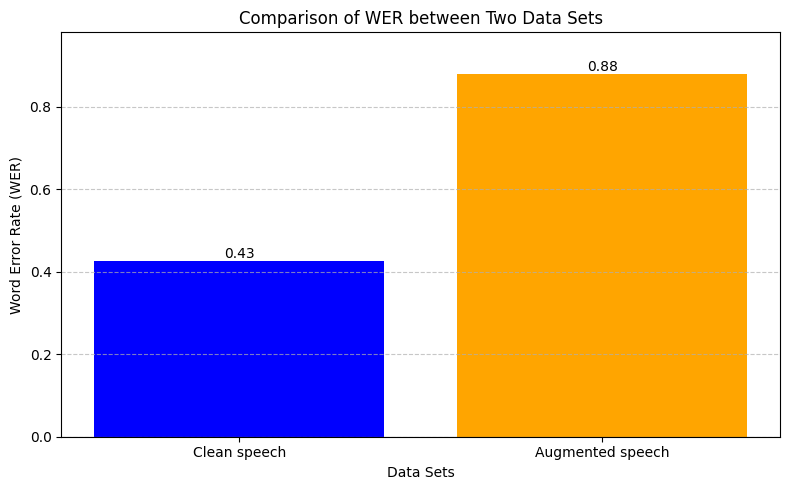

In [131]:

#load metrics
wer = load("wer")
cer = load("cer")

# Prepare lists for references and hypotheses
references = []
hypotheses = []

#Compute WER of whisper tiny on clean speech
for gt, asr in zip(ground_truth_transcriptions, clean_transcriptions):
    if gt[0] == asr[0]:  # Ensure that the utterance IDs match
        references.append(gt[1])  # Add ground truth transcription
        hypotheses.append(asr[1])  # Add ASR output transcription

wer_score_clean = jiwer.wer(references,hypotheses)
print(f"WER of Whisper Tiny.en on clean speech data: {wer_score_clean}")

references = []
hypotheses = []

#Compute WER of whisper tiny on augmented speech
for gt, asr in zip(ground_truth_transcriptions, augmented_transcriptions):
    if gt[0] == asr[0]:  # Ensure that the utterance IDs match
        references.append(gt[1])  # Add ground truth transcription
        hypotheses.append(asr[1])  # Add ASR output transcription

wer_score_aug = jiwer.wer(references,hypotheses)
print(f"WER of Whisper Tiny.en on augmented speech data: {wer_score_aug} \n")


wer_values = [wer_score_clean,wer_score_aug]
sets = ['Clean speech', 'Augmented speech']

#visualize WER
plt.figure(figsize=(8, 5))
plt.bar(sets, wer_values, color=['blue', 'orange'])
plt.xlabel('Data Sets')
plt.ylabel('Word Error Rate (WER)')
plt.title('Comparison of WER between Two Data Sets')
plt.ylim(0, max(wer_values) + 0.1)  # Adjust y-axis limit for better visualization
plt.axhline(y=0, color='gray', linewidth=0.8)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(wer_values):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()


Run the whole previous pipelien on all the 3 Augmented datasets to have the whole comaprison in the plot